In [2]:
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.4.0


# 生成数据集

使用线性模型来生成数据集。生成1000个样本的数据集：
$$ \mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b $$

In [4]:
# 设置输入数据的特征数量
num_inputs = 2
# 设置样本个数
num_examples = 1000

# 设置weight和bias来生成样本标签
true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, num_inputs, 
                       dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:,1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

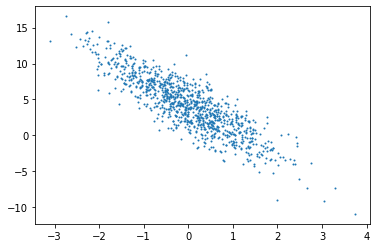

In [6]:
# 使用图像来展示生成的数据
plt.scatter(features[:,1].numpy(), labels.numpy(),1)

In [14]:
# 读取数据集
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) 
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size,num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

In [15]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.0032,  0.3820],
        [ 0.3153,  0.9454],
        [-2.3740, -2.0312],
        [-1.4019,  0.3800],
        [-0.1627, -1.0429],
        [ 0.5687, -1.2583],
        [-0.8281, -1.3141],
        [ 1.4041, -1.0073],
        [ 0.4864, -0.5903],
        [ 0.0455,  0.2313]]) 
 tensor([ 0.8981,  1.6103,  6.3513,  0.1047,  7.4271,  9.6192,  7.0126, 10.4240,
         7.1930,  3.5064])


In [16]:
# 初始化模型参数
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

# 定义模型
定义用来训练参数的训练模型：
$$ \mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b $$

In [17]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

#  定义损失函数
均方误差损失函数：
$$ l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,$$


In [18]:
def squared_loss(y_hat, y):
    return(y_hat - y.view(y_hat.size())) ** 2 / 2

# 定义优化函数
小批量随即梯度下降：
$$ (\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)$$

In [19]:
def sgd(params, lr, batch_size):
    for param in params:
        # ues .data to operate param without gradient track
        param.data -= lr * param.grad / batch_size

# 训练

In [20]:
# 超参数
lr = 0.03
num_epochs = 5

net = linreg
loss = squared_loss

# training
for epoch in range(num_epochs): # 训练将进行5轮
    # 在每个epoch数据集中所有的样本都会被使用一次
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()
        # 计算每个batch的样本的损失
        l.backward()
        # 使用小批量随即梯度下降迭代模型参数
        sgd([w, b], lr, batch_size)
        # 重置参数梯度
        w.grad.data.zero_()
        b.grad.data.zero_()
train_l = loss(net(features, w, b), labels)
print('epoch %d, loss %f' %(epoch + 1, train_l.mean().item()))

epoch 5, loss 0.000049


In [21]:
w, true_w, b, true_b

(tensor([[ 1.9992],
         [-3.4000]], requires_grad=True),
 [2, -3.4],
 tensor([4.1996], requires_grad=True),
 4.2)

# 简洁实现

In [22]:
from torch import nn
torch.manual_seed(1)

torch.set_default_tensor_type('torch.FloatTensor')

In [24]:
# 读取数据集
import torch.utils.data as Data

batch_size = 10

# combine featues and labels of dataset
dataset = Data.TensorDataset(features, labels)

# put dataset into DataLoader
data_iter = Data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2  # read data in multithreading
)


In [25]:
for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[-0.2953,  1.0055],
        [ 0.4321,  0.6781],
        [ 1.4870, -0.3713],
        [ 0.5753,  1.1931],
        [-0.2922,  1.0460],
        [-0.4579,  0.5607],
        [ 0.0097, -0.5291],
        [-0.3628,  0.6602],
        [-0.3385, -1.1277],
        [-0.1200, -0.8248]]) 
 tensor([0.1904, 2.7628, 8.4325, 1.2991, 0.0670, 1.3707, 6.0157, 1.2201, 7.3462,
        6.7551])


In [32]:
# ways to init a multilayer network
# method one
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # other layers can be added here
    )

# method two
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# method three
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [33]:
from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01)
init.constant_(net[0].bias, val=0.0)  # or you can use `net[0].bias.data.fill_(0)` to modify it directly

Parameter containing:
tensor([0.], requires_grad=True)

In [34]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0071,  0.0026]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [36]:
# 定义损失函数
loss = nn.MSELoss()

In [37]:
# 定义优化函数
import torch.optim as optim
optimizer = optim.SGD(net.parameters(),lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [39]:
# 训练
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d,loss:%f' % (epoch,l.item()))

epoch 1,loss:0.000218
epoch 2,loss:0.000076
epoch 3,loss:0.000086


In [40]:
# 参数对比
dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 1.9991, -3.4001]])
4.2 tensor([4.1999])
